# MSL Results

- Visualization of forecasts, reconstructions, anomaly scores, predicted and actual anomalies

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
import glob
cf.go_offline()
init_notebook_mode


<function plotly.offline.offline.init_notebook_mode(connected=False)>

In [528]:
# output_path = '../output/SMAP'
output_path = '../output/SMD/1-3'

In [529]:
pot = pd.read_pickle(f'{output_path}/anomaly_preds.pkl')
pot['anomaly'] = pot['anomaly'].astype(int)
pot.head()

a_score  threshold  pred_anomaly  anomaly
0  0.016758    0.09684             0        0
1  0.018877    0.09684             0        0
2  0.020665    0.09684             0        0
3  0.015857    0.09684             0        0
4  0.015196    0.09684             0        0

In [530]:
output = pd.read_pickle(f'{output_path}/preds.pkl')
test_anomaly_scores = np.load(f"{output_path}/test_scores.npy")

output['Tot_A_Score'] = test_anomaly_scores
output['Pred_Anomaly'] = pot['pred_anomaly']
output['True_Anomaly'] = pot['anomaly']
output['threshold'] = pot['threshold']


output.head()
#plt.tight_layout()
#colors = ['gray', 'gray', 'gray', 'r']*(output.shape[1] // 4)
#output.iloc[:, :].plot(subplots=True, style=colors, ylim=(0, 5))
#plt.show();

Pred_0   Recon_0    True_0  A_Score_0    Pred_1   Recon_1    True_1  \
0  0.196948  0.194820  0.191919   0.007929  0.011032  0.010147  0.008733   
1  0.203556  0.198243  0.212121   0.022444  0.011486  0.010451  0.008510   
2  0.203922  0.201578  0.212121   0.018742  0.011510  0.010556  0.016298   
3  0.206218  0.204179  0.191919   0.026560  0.011635  0.010685  0.014573   
4  0.207488  0.205125  0.212121   0.011628  0.011704  0.010967  0.012460   

   A_Score_1    Pred_2   Recon_2  ...  True_36  A_Score_36   Pred_37  \
0   0.003712  0.011313  0.010922  ...      0.0    0.001074 -0.000220   
1   0.004918  0.011736  0.011007  ...      0.0    0.001162 -0.000233   
2   0.010530  0.011758  0.011067  ...      0.0    0.001217 -0.000234   
3   0.006826  0.011864  0.011128  ...      0.0    0.001285 -0.000239   
4   0.002250  0.011922  0.011385  ...      0.0    0.001337 -0.000241   

   Recon_37  True_37  A_Score_37  Tot_A_Score  Pred_Anomaly  True_Anomaly  \
0 -0.002052      0.0    0.002272     0.016758             0             0   
1 -0.002039      0.0    0.002273     0.018877             0             0   
2 -0.001963      0.0    0.002197     0.020665             0             0   
3 -0.001966      0.0    0.002205     0.015857             0             0   
4 -0.001932      0.0    0.002173     0.015196             0             0   

   threshold  
0    0.09684  
1    0.09684  
2    0.09684  
3    0.09684  
4    0.09684  

[5 rows x 156 columns]

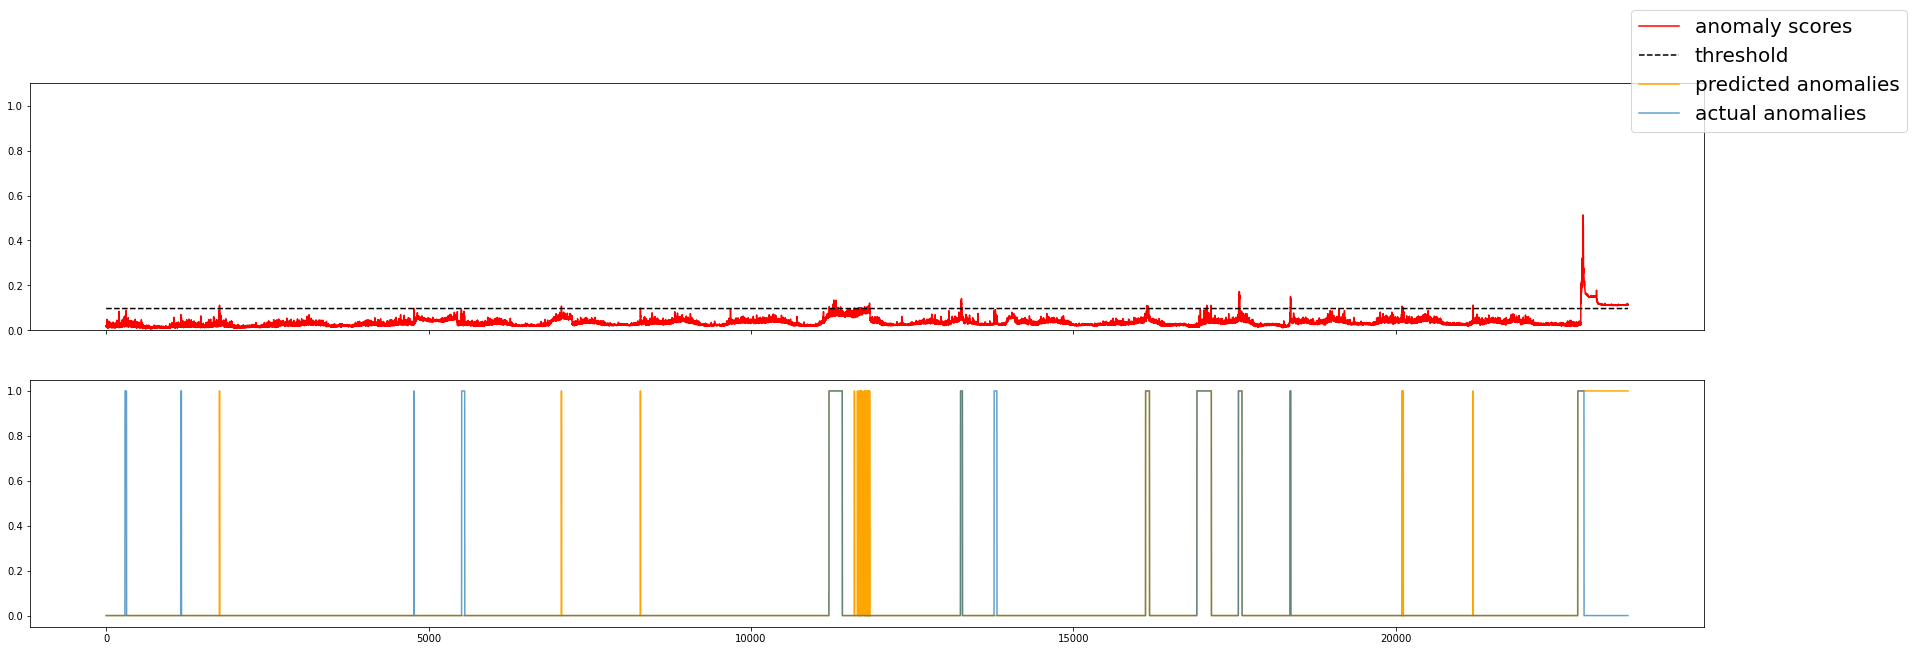

In [531]:
fig, axs = plt.subplots(2, figsize=(30, 10), sharex=True, )
axs[0].plot(pot['a_score'], c='r', label='anomaly scores')
axs[0].plot(pot['threshold' if 'threshold' in pot.columns else 'pot_threshold'], linestyle='dashed', c='black', label='threshold')
axs[1].plot(pot['pred_anomaly'], label='predicted anomalies', c='orange')
axs[1].plot(pot['anomaly'], label='actual anomalies', alpha=0.7)
axs[0].set_ylim([0, 1.1])

fig.legend(prop={'size': 20})
plt.show()

In [532]:
print('precision: ', precision_score(pot['anomaly'], pot['pred_anomaly']))
print('recall:    ', recall_score(pot['anomaly'], pot['pred_anomaly']))
print('f1 score:  ', f1_score(pot['anomaly'], pot['pred_anomaly']))

precision:  0.4907142857142857
recall:     0.8408812729498164
f1 score:   0.6197564276048715


In [454]:
def create_shapes(ranges, sequence_type, _min, _max, plot_values):
    """
    Create shapes for regions to highlight in plotly vizzes (true and
    predicted anomaly sequences). Will plot labeled anomalous ranges if
    available.

    Args:
        ranges (list of tuples): tuple of start and end indices for anomaly
            sequences for a channel
        sequence_type (str): "predict" if predicted values else
            "true" if actual values. Determines colors.
        _min (float): min y value of series
        _max (float): max y value of series
        plot_values (dict): dictionary of different series to be plotted
            (predicted, actual, errors, training data)

    Returns:
        (dict) shape specifications for plotly
    """

    if not _max:
        _max = max(plot_values['errors'])

    color = 'red' if sequence_type == 'true' else 'blue'
    shapes = []

    for r in ranges:
        shape = {
            'type': 'rect',
            'x0': r[0]-30, #self.config.l_s,
            'y0': _min,
            'x1': r[1]+0, #self.config.l_s,
            'y1': _max,
            'fillcolor': color,
            'opacity': 0.2,
            'line': {
                'width': 0,
            }
        }
        shapes.append(shape)

    return shapes

In [438]:
def get_anomaly_sequences(values):
    splits = np.where(values[1:] != values[:-1])[0] + 1
    
    a_seqs = []
    for i in range(0, len(splits)-1, 2):
        a_seqs.append([splits[i], splits[i+1]-1])

    if len(splits) % 2 == 1:
        a_seqs.append([splits[-1], len(values)-1])

    return a_seqs

In [552]:
def plot_channel(output, channel, show_tot_err=False, start=None, end=None, plot_errors=True):
    """ Plot forecasting, reconstruction, true value of a specific channel (feature),
        along with the anomaly score for that channel
    """

    output_copy = output.copy()
    if start is not None and end is not None:
        assert(start < end)
    if start is not None:
        output_copy = output_copy.iloc[start:, :]
    if end is not None:
        start = 0 if start is None else start
        output_copy = output_copy.iloc[:end-start, :]
    
    # output_copy = output_copy.reset_index()
    i = channel
    plot_values = {
    'y_forecast': output_copy[f'Pred_{i}'].values,
    'y_recon': output_copy[f'Recon_{i}'].values,
    'y_true': output_copy[f'True_{i}'].values,
    #'errors': output_copy[f'A_Score_{i}'].values,
    'errors': output_copy[f'Tot_A_Score'].values if show_tot_err else output_copy[f'A_Score_{i}'].values,
    'threshold': output_copy['threshold'].values,
    }
    
    anomaly_sequences = {
        'pred': get_anomaly_sequences(output_copy['Pred_Anomaly'].values),
        'true': get_anomaly_sequences(output_copy['True_Anomaly'].values)
    }
    
    y_min = plot_values['y_true'].min()
    y_max = plot_values['y_true'].max()
    e_max = plot_values['errors'].max()
    
    y_min -= 0.3*y_max
    y_max += 0.5*y_max
    e_max += 0.5*e_max
    
    #y_shapes = create_shapes(segments, 'true', y_min, y_max, plot_values)
    y_shapes = create_shapes(anomaly_sequences['true'], 'true', y_min, y_max, plot_values)
    e_shapes = create_shapes(anomaly_sequences['true'], 'true', 0, e_max, plot_values)
    
    y_shapes += create_shapes(anomaly_sequences['pred'], 'predicted', y_min, y_max, plot_values)
    e_shapes += create_shapes(anomaly_sequences['pred'], 'predicted', 0, e_max, plot_values)

    y_df = pd.DataFrame({
        'y_forecast': plot_values['y_forecast'].reshape(-1,),
        'y_recon': plot_values['y_recon'].reshape(-1,),
        'y_true': plot_values['y_true'].reshape(-1,)
    })

    e_df = pd.DataFrame({
        'e_s': plot_values['errors'].reshape(-1,),
        'threshold': plot_values['threshold'].reshape(-1,)
    })

    y_layout = {
        'title': f'Forecast & reconstruction vs true value for channel: {i} ',
        'shapes': y_shapes,
        'yaxis': dict(
            range=[y_min, y_max]
        ),
        'showlegend': True
    }

    e_layout = {
        'title': "Total error for all channels" if show_tot_err else f"Error for channel: {i}",
        'shapes': e_shapes,
        'yaxis': dict(
            range=[0, e_max]
        )
    }
    
    lines = [
        go.Scatter(x=y_df['y_true'].index, y=y_df['y_true'], line_color='rgb(0, 204, 150, 0.5)', name='y_true'),
        go.Scatter(x=y_df['y_forecast'].index, y=y_df['y_forecast'], line_color='rgb(255, 127, 14, 1)', name='y_forecast'),
        go.Scatter(x=y_df['y_recon'].index, y=y_df['y_recon'], line_color='rgb(31, 119, 180, 1)', name='y_recon'), 
    ]
        
    fig = go.Figure(
        data=lines,
        layout=y_layout#go.Layout(showlegend=True)
    )
    py.offline.iplot(fig)

    #y_df.iplot(kind='scatter', layout=y_layout, opacity=0.01)

    if plot_errors:
        e_df.iplot(kind='scatter', layout=e_layout, colors=['red', 'black'], dash=[None, 'dash'])
        #e_df.iplot(kind='scatter', layout=e_layout, colors=['red'])

In [427]:
# Meta data 
md = pd.read_csv('../datasets/data/labeled_anomalies.csv')
md = md[md['spacecraft']=='SMAP']
md = md.sort_values(by=['chan_id'])
md.head(10)

chan_id spacecraft anomaly_sequences         class  num_values
15     A-1       SMAP    [[4690, 4774]]       [point]        8640
22     A-2       SMAP    [[4450, 4560]]  [contextual]        7914
23     A-3       SMAP    [[4575, 4760]]  [contextual]        8205
24     A-4       SMAP    [[4550, 4660]]  [contextual]        8080
47     A-5       SMAP    [[2750, 2800]]       [point]        4693
48     A-6       SMAP    [[1890, 1930]]       [point]        4453
49     A-7       SMAP    [[6200, 8600]]  [contextual]        8631
52     A-8       SMAP    [[4569, 8374]]  [contextual]        8375
53     A-9       SMAP    [[4569, 8433]]  [contextual]        8434
42     B-1       SMAP    [[5060, 5130]]       [point]        8044

In [402]:
anomaly_sequences = md['anomaly_sequences'].values
e_seq = []
for i in range(len(anomaly_sequences)):
    seq = eval(anomaly_sequences[i])
    e_seq.append(seq)

print(e_seq[:5])

[[[4690, 4774]], [[4450, 4560]], [[4575, 4760]], [[4550, 4660]], [[2750, 2800]]]


In [416]:
v = md['num_values'].values
cuma_v = np.cumsum(v)
cuma_v = np.concatenate([[0], cuma_v])
print(cuma_v[:10])
np.where(cuma_v > 44000)

[    0  8640 16554 24759 32839 37532 41985 50616 58991 67425]


(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]),)

In [404]:
e_seq_cum = []
for i in range(len(e_seq)):
    for seq in e_seq[i]:
        seq_cum = [seq[0]+cuma_v[i], seq[1]+cuma_v[i]]
        e_seq_cum.append(seq_cum)

e_seq_cum[-5:]

[[420618, 422117],
 [424769, 424804],
 [433671, 435455],
 [437554, 437636],
 [440656, 440756]]

In [412]:
#v = md['num_values'].values
#cuma_v = np.cumsum(v)

#cuma_v = np.concatenate([[0], cuma_v])
#segments = [[cuma_v[i], cuma_v[i+1]] for i in range(len(cuma_v)-1)]
#segments = [segments[i] for i in range(len(segments)) if i%2==0]
#print(segments[:5])

In [408]:
#actual = output['True_0'].values
#new_preds = np.concatenate([[0], actual])
#new_preds = new_preds[:-1]
#display(output.head())
#output['Pred_0'] = new_preds
#output['Recon_0'] = new_preds
#output['Tot_A_Score'] = np.sqrt((new_preds - actual)**2) + np.sqrt((new_preds-actual)**2)

In [560]:
r = "4872-4875"
start, end = int(r.split('-')[0])-200, int(r.split('-')[1])+100
start, end = None, None
plot_channel(output, channel=27, show_tot_err=True, start=start, end=end)

In [154]:
output.iloc[4580:4600, :].head(50)

Pred_0   Recon_0  True_0  A_Score_0  Tot_A_Score  Pred_Anomaly  \
4580  1.000174  1.000540     1.0   0.000714     0.000714             0   
4581  1.000034  1.000320     1.0   0.000354     0.000354             0   
4582  0.999993  1.000528     1.0   0.000535     0.000535             0   
4583  1.000021  0.999510     1.0   0.000511     0.000511             0   
4584  1.002677  1.000297     1.0   0.002974     0.002974             0   
4585  0.997963  0.998228     1.0   0.003809     0.003809             0   
4586  1.006017  0.998861     1.0   0.007157     0.007157             0   
4587  1.006972  1.000333     1.0   0.007305     0.007305             0   
4588  0.998673  0.997833     1.0   0.003493     0.003493             0   
4589  1.001543  0.998624     1.0   0.002918     0.002918             0   
4590  0.996508  0.997892     1.0   0.005600     0.005600             1   
4591  1.002615  0.999630     1.0   0.002985     0.002985             1   
4592  1.001917  0.999525     1.0   0.002391     0.002391             1   
4593  0.999665  0.999420     1.0   0.000915     0.000915             1   
4594  0.999365  1.000203     1.0   0.000838     0.000838             1   
4595  1.000244  1.000226     1.0   0.000469     0.000469             1   
4596  1.000288  0.999939     1.0   0.000349     0.000349             1   
4597  0.999836  0.999770     1.0   0.000395     0.000395             1   
4598  0.999455  0.999977     1.0   0.000568     0.000568             1   
4599  0.999454  1.000220     1.0   0.000766     0.000766             1   

      True_Anomaly  threshold  
4580             0   0.720246  
4581             0   0.720246  
4582             0   0.720246  
4583             0   0.720246  
4584             0   0.720246  
4585             0   0.720246  
4586             0   0.720246  
4587             0   0.720246  
4588             0   0.720246  
4589             0   0.720246  
4590             1   0.720246  
4591             1   0.720246  
4592             1   0.720246  
4593             1   0.720246  
4594             1   0.720246  
4595             1   0.720246  
4596             1   0.720246  
4597             1   0.720246  
4598             1   0.720246  
4599             1   0.720246